<a href="https://colab.research.google.com/github/Crepopcorn/IE4476_project/blob/main/IE4476_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load Libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
# Load images
def load_im():
    input_im, input_label = [], []
    resize = (224, 224)
    # Loop in folders
    for dirname, _, filenames in os.walk('/content/drive/My Drive/IE4476_dataset'):
        for filename in filenames:
            photo_path = os.path.join(dirname, filename)
            photo_class = dirname.split('/')[-1]
            try:
                read_im = cv2.imread(photo_path)
                input_im.append(cv2.resize(read_im, resize))

                if photo_class == 'rock':
                    input_label.append(0)
                elif photo_class == 'paper':
                    input_label.append(1)
                elif photo_class == 'scissor':
                    input_label.append(2)
            except:
                print(photo_path)
    # return list of images and another list of correponding labels
    return input_im, input_label

input_im, input_label = load_im()

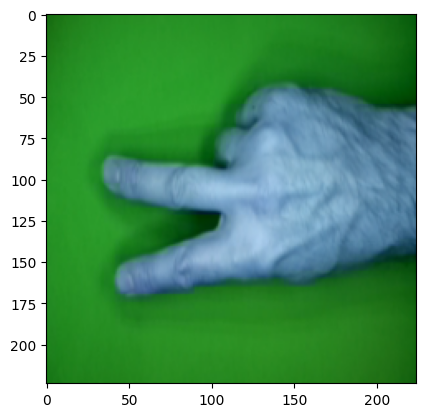

2


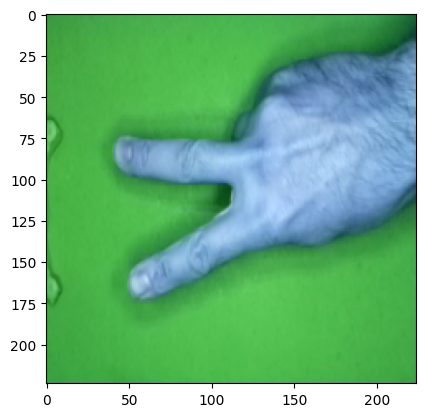

2


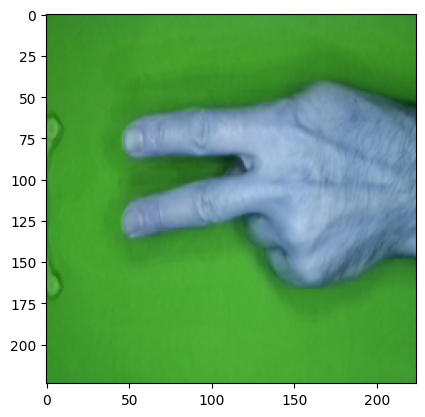

2


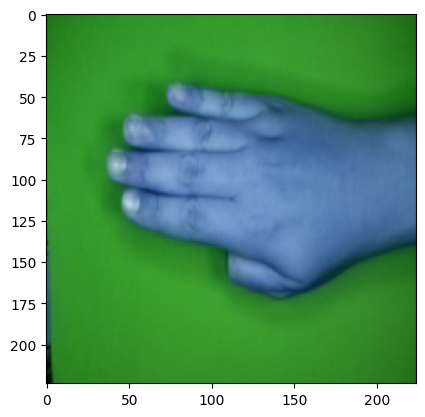

1


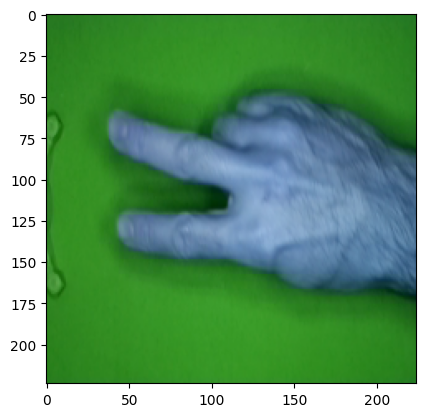

2


In [4]:
# Checking code: Print photo and class
index_set = np.random.choice(len(input_label), size = 5, replace = False)
for index in index_set:
    # show images
    plt.imshow(input_im[index])
    plt.show()
    # show label
    print(input_label[index])

In [5]:
# Train/Test split
def train_test_split(test_prop, input_im, input_label):
    # Random sampling of index
    test_size = int(np.floor(test_prop * len(input_label)))
    test_index = np.random.choice(len(input_label), size = test_size, replace = False)
    # Split
    train_x, test_x, train_y, test_y = np.delete(input_im, test_index, axis = 0), np.take(input_im, test_index, axis = 0), np.delete(input_label, test_index, axis = 0), np.take(input_label, test_index, axis = 0)
    # Return train and test sets for both images and labels
    return train_x, test_x, train_y, test_y, test_index

# 80/20 split for small data set
test_prop = 0.2
train_x, test_x, train_y, test_y, test_index = train_test_split(test_prop, input_im, input_label)

In [6]:
def append_im(input_im, input_label, im_iterator):
    input_label_n = input_label.copy()
    input_im_n = input_im.copy()
    for i in range(len(im_iterator)):
        im = im_iterator[i]
        im = im.astype('uint8')
        im_lbl = [input_label[i]]
        input_im_n = np.append(input_im_n, im, axis = 0)
        input_label_n = np.append(input_label_n, im_lbl, axis = 0)
    return input_im_n, input_label_n

In [7]:
# Flipping
flip_data_generator = ImageDataGenerator(horizontal_flip = True)
im_iterator = flip_data_generator.flow(train_x, batch_size = 1, shuffle = False)
input_im_n, input_label_n = append_im(train_x, train_y, im_iterator)

In [8]:
# Reshape
nx, ny, nz = train_x.shape[1], train_x.shape[2], train_x.shape[3]
train_x_nn, test_x_nn = input_im_n, test_x
train_x = input_im_n.reshape((input_im_n.shape[0], nx * ny * nz)) / 255
test_x = test_x.reshape((test_x.shape[0], nx * ny * nz)) / 255
train_y = input_label_n.reshape((input_label_n.shape[0], 1))
test_y = test_y.reshape((test_y.shape[0], 1))

In [9]:
# Dimensionality reduction - Full PCA
im_pca = PCA()
im_pca.fit(train_x)
variance_explained_list = im_pca.explained_variance_ratio_.cumsum()
print(variance_explained_list)

[0.19808007 0.31517644 0.39616965 ... 1.         1.         1.        ]


In [10]:
test_x_pca = im_pca.transform(test_x)
train_x_pca = im_pca.transform(train_x)

In [11]:
import time
start_time = time.time()

# Support vector machine with PCA
def svm_grid_search(C, kernel, train_x, train_y, test_x):
    accuracy_score_list = []
    val_acc_score_list = []

    for c in C:
        # Model training
        svmClassifier = svm.SVC(C = c, kernel = kernel)
        svmClassifier.fit(train_x, train_y.ravel())
        # Prediction on training set
        pred_y = svmClassifier.predict(train_x)
        # Prediction on training set
        pred_y_test = svmClassifier.predict(test_x)
        # Accuracy
        accuracy = accuracy_score(train_y, pred_y)
        val_accuracy = accuracy_score(test_y, pred_y_test)

        accuracy_score_list.append(accuracy)
        val_acc_score_list.append(val_accuracy)

        print('Regularization parameters: {0:.1f}'.format(c), 'Training Accuracy: ', accuracy)
        print('Regularization parameters: {0:.1f}'.format(c), 'Validation Accuracy: ', val_accuracy)

    max_accurarcy_id = accuracy_score_list.index(max(accuracy_score_list))
    return C[max_accurarcy_id] ,accuracy_score_list, val_acc_score_list

C, kernel = [0.1 * i for i in range(1, 30)], 'rbf'
opt_C, acc_list, val_list = svm_grid_search(C, kernel, train_x_pca, train_y, test_x_pca)

print("--- %s seconds ---" % (time.time() - start_time))

Regularization parameters: 0.1 Training Accuracy:  0.9286122215876642
Regularization parameters: 0.1 Validation Accuracy:  0.9016018306636155
Regularization parameters: 0.2 Training Accuracy:  0.9591661907481439
Regularization parameters: 0.2 Validation Accuracy:  0.9290617848970252
Regularization parameters: 0.3 Training Accuracy:  0.970873786407767
Regularization parameters: 0.3 Validation Accuracy:  0.9427917620137299
Regularization parameters: 0.4 Training Accuracy:  0.9782981153626499
Regularization parameters: 0.4 Validation Accuracy:  0.9473684210526315
Regularization parameters: 0.5 Training Accuracy:  0.9802969731581953
Regularization parameters: 0.5 Validation Accuracy:  0.9473684210526315
Regularization parameters: 0.6 Training Accuracy:  0.9828669331810395
Regularization parameters: 0.6 Validation Accuracy:  0.9496567505720824
Regularization parameters: 0.7 Training Accuracy:  0.9851513420902341
Regularization parameters: 0.7 Validation Accuracy:  0.9519450800915332
Regular

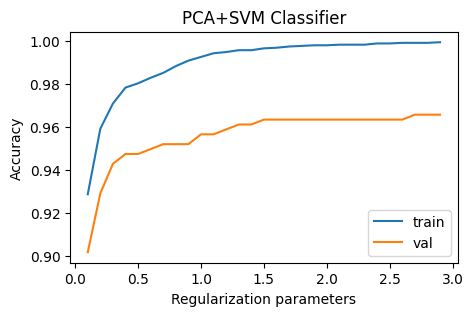

In [12]:
import matplotlib.pyplot as plt
import numpy as np
x_list = [0.1 * i for i in range(1, 30)]
plt.figure(figsize=(5,3))
plt.plot(x_list, acc_list)
plt.plot(x_list, val_list)
plt.title('PCA+SVM Classifier')
plt.ylabel('Accuracy')
plt.xlabel('Regularization parameters')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [13]:
print("Training Accuracy: {0:.2f}%".format(max(acc_list)*100))
print("Testing Accuracy: {0:.2f}%".format(max(val_list)*100))

Training Accuracy: 99.94%
Testing Accuracy: 96.57%


In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def confussion_matrix(test_true, test_pred, test_class):
    cm = confusion_matrix(test_true, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class)
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax,cmap=plt.cm.Blues)
    plt.show()

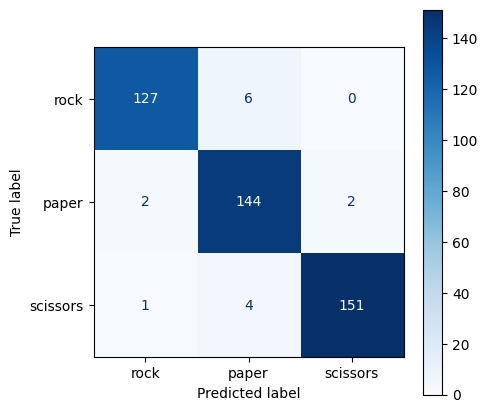

In [15]:
test_classes = ['rock','paper','scissors']
svmClassifier = svm.SVC(C = opt_C, kernel = kernel)
svmClassifier.fit(train_x_pca, train_y.ravel())
pred_y = svmClassifier.predict(test_x_pca)
confussion_matrix(test_y, pred_y, test_classes)